# Neural Networks for Data Science Applications
## Mid-term Homework: Implementing a custom activation function

**Name**: *\<Alexandru Melnic\>*

**Matricola**: *\<1692625\>*

Send the completed notebook before 26/11/2020 back to **simone.scardapane@uniroma1.it** with the object "[NNDS] Homework_1_\<id\>".

In [1]:
import tensorflow as tf

### Introduction

The **exponential linear unit** (ELU) is an activation function defined as [1]:

$$
\phi(x) =
\Biggl\{ 
\begin{align} 
x & \;\; \text{ if } x \ge 0 \\
\alpha \left(\exp\left(x\right)- 1\right) & \;\; \text{ otherwise } 
\end{align}
\Bigr.
\,,
$$

where $\alpha$ is a hyper-parameter. The function is implemented in `tf.keras.layers.ELU` (see the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ELU)).

The **parametric ELU** (PELU) extends the ELU activation function as [2]:

$$
\phi(x) =
\Biggl\{ 
\begin{align} 
\frac{\alpha}{\beta}x & \;\; \text{ if } x \ge 0 \\
\alpha \left(\exp\Bigl(\frac{x}{\beta}\Bigr)- 1\right) & \;\; \text{ otherwise } 
\end{align}
\Bigr.
\,,
$$

where the major difference is that $\alpha,\beta > 0$ are *trainable* parameters, i.e., a pair of $(\alpha, \beta)$ values is trained for each unit in the network.

### Exercise 1: implement the PELU

In TensorFlow, it is possible to implement new layers by subclassing `tf.keras.layers.Layer`:

+ [Making new Layers and Models via subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models)
+ [Custom layers](https://www.tensorflow.org/tutorials/customization/custom_layers)
+ [tf.keras.layers.Layer (documentation)](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer)

**Exercise 1**: *After carefully reading the guides*, complete the following implementation of the PELU activation function.

In [3]:
from tensorflow.keras.constraints import NonNeg

class PELU(tf.keras.layers.Layer):

    def __init__(self, units=32):
        super(PELU, self).__init__()
        self.units = units

    def build(self, input_shape=_):

        param_init = tf.random_uniform_initializer(minval=0.1, maxval=1)

        self.params = self.add_weight(
            shape = (self.units, 2), 
            initializer = param_init, 
            trainable = True, 
            constraint = NonNeg(), 
            dtype='float32'
        )

    def call(self, inputs):

        a, b = self.params[:,0], self.params[:,1]
        return a/b*inputs*tf.cast(inputs>=0, dtype='float32') + a*(tf.exp(inputs/b*tf.cast(inputs<0, dtype='float32'))-1)

**Hints for a correct implementation**:

1. The layer (probably) requires two sets of trainable variables, whose shape depends on the number of units.
2. From the definition of the PELU, $\alpha, \beta$ are required to be positive in order to ensure differentiability. The simplest way to handle this is to use a [constraint callable](https://www.tensorflow.org/api_docs/python/tf/keras/constraints) when creating the weight (see also the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer) for `add_weight`).

### Exercise 2: some preliminary tests

To evaluate your implementation, let us start by creating a single PELU function:

**Exercise 2.1**: plot the function using the skeleton code below.

In [4]:
pelu = PELU(units=1)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



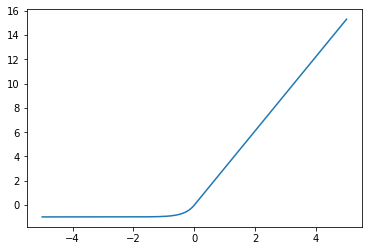

In [5]:
import numpy as np
import matplotlib.pyplot as plt

x_range = tf.linspace(-5, 5, 200) # An equispaced grid of 200 points in [-5, +5]

y_range = pelu(x_range)

plt.plot(x_range.numpy(), y_range.numpy())

The derivative of a PELU function with respect to the $\alpha$ parameter is given by [2]:

$$
\frac{d\phi(x)}{d\alpha} =
\Biggl\{ 
\begin{align} 
\frac{x}{\beta} & \;\; \text{ if } x \ge 0 \\
 \left(\exp\Bigl(\frac{x}{\beta}\Bigr)- 1\right) & \;\; \text{ otherwise } 
\end{align}
\Bigr.
\,,
$$


**Exercise 2.2**: using a `tf.GradientTape` object, compute the derivative above using automatic differentiation, and check its correctness up to a certain numerical precision.

**Hints for a correct implementation**:

1. `tf.GradientTape` allows to compute the derivative *at a single point x*. If you prefer to avoid a loop over all possible points, consider using the `jacobian` function to obtain them in a single pass ([Advanced Automatic Differentiation](https://www.tensorflow.org/guide/advanced_autodiff)).
2. Given two tensors x and y, a simple way to compute elementwise similarity up to a certain precision (e.g., $10^{-4}$), is given by `tf.reduce_all(tf.abs(x - y) < 1e-4)`.

**Exercise 2.3 (optional)**: try the same for the $\beta$ parameter (you can check the analytical formula for the gradient in the original paper [2]). **Careful**: the equation in the original paper has a missing $h$ (thanks to Davide Aureli and Federico Siciliano for spotting this). See [the correct derivation](https://www.wolframalpha.com/input/?i=d%28a*%28exp%28h%2Fb%29-1%29%29%2Fdb) on Wolfram Alpha.

In [6]:
# Analytical gradient
def pelu_gradient(x, params):
    a, b = params[:,0], params[:,1]
    
    grad_a = tf.where(x>=0, x/b, tf.exp(x/b)-1)
    grad_b = tf.where(x>=0, -a/b**2*x, -a*x/b**2*tf.exp(x/b))
    
    return tf.stack([grad_a, grad_b], axis=1)

In [7]:
# tf gradient

pelu = PELU(units=1)

with tf.GradientTape() as tape:
    
    pelu_fun = pelu(x_range)

grad = tape.jacobian(pelu_fun, pelu.params)

tf_gradient = tf.reshape(grad, shape=(-1, 2))
my_gradient = pelu_gradient(tf.cast(x_range, tf.float32), pelu.params)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [8]:
# check the difference between the two

tf.reduce_all(tf.abs(tf_gradient - my_gradient) < 1e-4)

<tf.Tensor: shape=(), dtype=bool, numpy=True>

### Exercise 3: PELU in practice

Consider a simple model built with the PELU activation function, as below.

In [19]:
model = tf.keras.Sequential(layers=[
      tf.keras.layers.Dense(50),
      PELU(50),
      tf.keras.layers.Dense(10, activation='softmax')
])

In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

train_set = pd.read_csv('/content/sample_data/mnist_train_small.csv', header=None)
X = train_set.iloc[:, 1:].values.astype('float32')
y = train_set.iloc[:, 0].values.reshape(-1,1).astype('float32')
del train_set

test_set = pd.read_csv('/content/sample_data/mnist_test.csv', header=None)
X_test = test_set.iloc[:, 1:].values.astype('float32')
y_test = test_set.iloc[:, 0].values.reshape(-1,1).astype('float32')
del test_set

BATCH_SIZE = 32
scaler = StandardScaler()
scaler.fit(X)

train_set = tf.data.Dataset.from_tensor_slices((scaler.transform(X), y))
train_set = train_set.shuffle(buffer_size = 1000).batch(BATCH_SIZE)

test_set = tf.data.Dataset.from_tensor_slices((scaler.transform(X_test), y_test)).batch(BATCH_SIZE)

In [20]:
NUM_EPOCH = 10

model.compile(optimizer=tf.keras.optimizers.SGD(1e-3), 
            loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
            metrics='accuracy')

model.fit(train_set, epochs=NUM_EPOCH)
model.evaluate(test_set)

Epoch 1/10
625/625 [==============================] - 1s 2ms/step - loss: 1.4755 - accuracy: 0.5688
Epoch 2/10
625/625 [==============================] - 1s 2ms/step - loss: 0.7294 - accuracy: 0.7983
Epoch 3/10
625/625 [==============================] - 1s 2ms/step - loss: 0.5662 - accuracy: 0.8415
Epoch 4/10
625/625 [==============================] - 1s 2ms/step - loss: 0.4832 - accuracy: 0.8637
Epoch 5/10
625/625 [==============================] - 1s 2ms/step - loss: 0.4304 - accuracy: 0.8781
Epoch 6/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3940 - accuracy: 0.8867
Epoch 7/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3661 - accuracy: 0.8935
Epoch 8/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3439 - accuracy: 0.8994
Epoch 9/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3255 - accuracy: 0.9048
Epoch 10/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3100 - accuracy: 0.9091

[0.34478333592414856, 0.9059000015258789]

**Exercise 3**: load any classification dataset, and train the model above (using either a custom training loop or `model.fit(...)`). Additionally, compare with a standard ReLU activation.

In the next cells there will be the confront between the model with the ReLU and the one with the PELU. The two models will have the same hyperparameters: 10 epochs, SGD optimizer with lr 10**-3. The confront will be on the fitting time, evaluation time,  the train loss and accuracy and the test loss and accuracy. All the experiment will be repeated 20 times and at the end the averages of all the measurements will be shown.


In [37]:
#@title Code needed to confront the pelu and relu models
from time import time
from tqdm import tqdm

iterations = 20
NUM_EPOCH = 10

tot_stats_pelu = []
tot_stats_relu = []

for i in tqdm(range(iterations)):

    current_stats = []
    tf.keras.backend.clear_session()
    model = tf.keras.Sequential(layers=[
        tf.keras.layers.Dense(50),
        PELU(50),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
                  optimizer = tf.keras.optimizers.SGD(10**-3), 
                  metrics = 'accuracy')
    
    start_time = time() # for training time
    history_pelu = model.fit(train_set, 
                             epochs = NUM_EPOCH, 
                             callbacks=[tf.keras.callbacks.History()],
                             verbose = 0)
    current_stats.append(time() - start_time)

    start_time = time() # for evaluation time
    test_results_pelu = model.evaluate(test_set, verbose=0)
    current_stats.append(time() - start_time)

    current_stats.append(history_pelu.history['loss'][-1])
    current_stats.append(history_pelu.history['accuracy'][-1])
    current_stats.append(test_results_pelu[0])
    current_stats.append(test_results_pelu[1])
    tot_stats_pelu.append(current_stats)




    current_stats = []
    tf.keras.backend.clear_session()
    model = tf.keras.Sequential(layers=[
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
                  optimizer = tf.keras.optimizers.SGD(10**-3), 
                  metrics = 'accuracy')
    
    start_time = time() # for training time
    history_relu = model.fit(train_set, 
                             epochs = NUM_EPOCH,
                             callbacks=[tf.keras.callbacks.History()],
                             verbose = 0)
    current_stats.append(time() - start_time)

    start_time = time() # for evaluation time
    test_results_relu = model.evaluate(test_set, verbose=0)
    current_stats.append(time() - start_time)

    current_stats.append(history_relu.history['loss'][-1])
    current_stats.append(history_relu.history['accuracy'][-1])
    current_stats.append(test_results_relu[0])
    current_stats.append(test_results_relu[1])
    tot_stats_relu.append(current_stats)


100%|██████████| 20/20 [06:44<00:00, 20.24s/it]


In [38]:
# save results in a dataframe

pelu_results = pd.DataFrame(tot_stats_pelu, columns = [ 'fit_time','eval_time' ,'loss', 'acc', 'test_loss', 'test_acc'])
relu_results = pd.DataFrame(tot_stats_relu, columns = [ 'fit_time','eval_time' ,'loss', 'acc', 'test_loss', 'test_acc'])

Average measurements for the model with ReLU after 10 epochs.

In [39]:
relu_results.mean()

fit_time     8.551721
eval_time    0.431712
loss         0.381503
acc          0.894495
test_loss    0.400977
test_acc     0.893500
dtype: float64

Average measurements for the model with PELU after 10 epochs.

In [40]:
pelu_results.mean()

fit_time     10.740577
eval_time     0.483712
loss          0.315165
acc           0.907705
test_loss     0.379020
test_acc      0.900610
dtype: float64

From the results above it is possible to notice that in average the training time for 10 epochs is lower in the ReLU model, that is reasonable since the computation for the PELU is higher and every feauture has a custom activation function. Lastly, the accuracy and loss on the test set of the PELU is higher than the ReLU.

### Optional: understanding saving/loading of models

TensorFlow has several options for saving or loading objects from the disk:

1. [Save and load Keras models](https://www.tensorflow.org/guide/keras/save_and_serialize/)

In many cases, custom classes require the implementation of a `get_config` / `from_config` functions to define the serialization behaviour.

**Exercise 4 (optional)**: implement the `get_config` method and test your implementation as below (taken from the guide on saving and loading models).

In [ ]:
model = tf.keras.Sequential(layers=[
      tf.keras.layers.Dense(50),
      PELU(50),
      tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
model.save('pelu_model')
del PELU # This is needed to remove any reference to PELU from memory
reloaded_model = tf.keras.models.load_model('pelu_model')

In [ ]:
print("Original model:", model)
print("Loaded model:", reloaded_model) # Observe that the object has been dynamically recreated in absence of the configuration options

### References

[1] Clevert, D.A., Unterthiner, T. and Hochreiter, S., 2015. [Fast and accurate deep network learning by exponential linear units (ELUs)](https://arxiv.org/abs/1511.07289). arXiv preprint arXiv:1511.07289.

[2] Trottier, L., Gigu, P. and Chaib-draa, B., 2017. [Parametric exponential linear unit for deep convolutional neural networks](https://arxiv.org/abs/1605.09332). In 2017 16th IEEE International Conference on Machine Learning and Applications (ICMLA) (pp. 207-214). IEEE.